## Installing prerequisities:

In [1]:
!pip install numpy pandas torch torchvision torchmetrics matplotlib mplcyberpunk

Defaulting to user installation because normal site-packages is not writeable


## Importing necessary libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import TensorDataset as Dataset
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from PIL import Image
import os
import time
import gc
import mplcyberpunk
plt.style.use('cyberpunk')

## Data extraction and processing:

You can download the dataset from this: **https://drive.google.com/file/d/1k2A7dJgQ25-Tqzmda49kJElo-1vhbEQk/view?usp=sharing**

And place it where the next cell can find it!

In [4]:
df = pd.read_csv("fer2013.csv")
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
def str_to_arr(x):     # Since the images are stored as a long string of pixel values
    x = x.split(" ")
    return [int(i) for i in x]

df["pixels"] = df["pixels"].apply(lambda x: str_to_arr(x))
df

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training
...,...,...,...
35882,6,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...",PrivateTest
35883,3,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ...",PrivateTest
35884,0,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...",PrivateTest
35885,3,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...",PrivateTest


## Visualizing a sample:

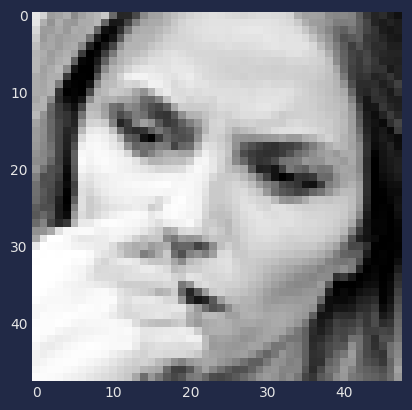

In [6]:
index = 2
img = np.array(df["pixels"].loc[index]).reshape(48,48)
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.show()

## Adding Gaussian noise:

In [7]:
def add_gaussian_noise(pixels, mean=0, std=10):
    noise = np.random.normal(mean, std, len(pixels))
    noisy_pixels = np.clip(pixels + noise, 0, 255).astype(np.uint8)
    return noisy_pixels

df['noisy'] = df['pixels'].apply(lambda x: add_gaussian_noise(np.array(x), mean=2, std=15))
df

,emotion,pixels,Usage,noisy
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training,"[61, 81, 86, 82, 79, 69, 41, 62, 65, 83, 50, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training,"[150, 136, 150, 162, 159, 153, 111, 145, 161, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training,"[248, 215, 174, 177, 185, 128, 174, 171, 188, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training,"[0, 36, 45, 37, 9, 12, 8, 31, 40, 40, 28, 26, ..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training,"[3, 20, 0, 0, 25, 13, 11, 2, 3, 0, 12, 7, 20, ..."
...,...,...,...,...
35882,6,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...",PrivateTest,"[68, 8, 26, 28, 9, 26, 7, 34, 46, 40, 41, 18, ..."
35883,3,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ...",PrivateTest,"[182, 167, 197, 189, 190, 164, 213, 199, 200, ..."
35884,0,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...",PrivateTest,"[10, 51, 26, 6, 26, 21, 0, 33, 19, 46, 4, 12, ..."
35885,3,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...",PrivateTest,"[41, 25, 24, 56, 21, 11, 61, 74, 60, 67, 56, 4..."


## Visualizing noisy image:

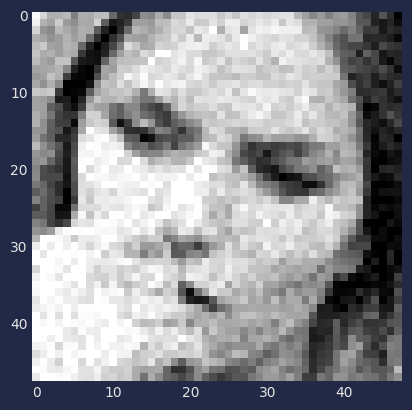

In [8]:
img = np.array(df["noisy"].loc[index]).reshape(48,48)
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.show()

## Defining Dataset for better data management:

In [9]:
class ImageDataset(Dataset):
    def __init__(self, images, noises, device):
        self.images = images
        self.noises = noises
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images.iloc[idx], dtype=torch.float32).reshape(1, 48, 48).to(self.device)
        noise = torch.tensor(self.noises.iloc[idx], dtype=torch.float32).reshape(1, 48, 48).to(self.device)
        return image, noise


## Train/Test split:

In [10]:
train_set = df[df["Usage"] == "Training"][["pixels", "noisy"]]
test_set = df[df["Usage"] == "PrivateTest"][["pixels", "noisy"]]
val_set = df[df["Usage"] == "PublicTest"][["pixels", "noisy"]]
train_set

,pixels,noisy
0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...","[61, 81, 86, 82, 79, 69, 41, 62, 65, 83, 50, 4..."
1,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...","[150, 136, 150, 162, 159, 153, 111, 145, 161, ..."
2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...","[248, 215, 174, 177, 185, 128, 174, 171, 188, ..."
3,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...","[0, 36, 45, 37, 9, 12, 8, 31, 40, 40, 28, 26, ..."
4,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...","[3, 20, 0, 0, 25, 13, 11, 2, 3, 0, 12, 7, 20, ..."
...,...,...
28704,"[84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 8...","[102, 90, 84, 95, 77, 100, 85, 78, 80, 82, 104..."
28705,"[114, 112, 113, 113, 111, 111, 112, 113, 115, ...","[124, 118, 148, 130, 113, 116, 141, 136, 141, ..."
28706,"[74, 81, 87, 89, 95, 100, 98, 93, 105, 120, 12...","[88, 77, 93, 81, 93, 73, 92, 116, 118, 101, 12..."
28707,"[222, 227, 203, 90, 86, 90, 84, 77, 94, 87, 99...","[224, 247, 204, 83, 83, 84, 107, 77, 57, 71, 9..."


## Creating dataloaders for loading efficiently:

In [11]:
train_dataset = ImageDataset(train_set["pixels"], train_set["noisy"], device="cuda:1")
test_dataset = ImageDataset(test_set["pixels"], test_set["noisy"], device="cuda:1")
val_dataset = ImageDataset(val_set["pixels"], val_set["noisy"], device="cuda:1")

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=16,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=16,
                                         shuffle=True)

# Model definition:

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=1,
                 depth=4, wf=6, padding=True,
                 batch_norm=True):
        
        super(UNet, self).__init__()
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        output = self.last(x)

        return output


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        block.append(nn.Dropout2d(p=0.15)) # edited
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetUpBlock, self).__init__()

        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Defining accuracy measurement metrics:

In [13]:
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to("cuda:1")

def compute_psnr(denoised, ground_truth, max_pixel_value=1.0):
    mse = torch.mean((denoised - ground_truth) ** 2)
    psnr = 10 * torch.log10(max_pixel_value**2 / mse)
    return psnr

def compute_mae(denoised, ground_truth):
    mae = torch.mean(torch.abs(denoised - ground_truth))
    return mae

# Training loop:

In [14]:
model = UNet(in_channels=1, n_classes=1, depth=4, wf=6,
             padding=True, batch_norm=True).to("cuda:1")

criterion = MSELoss()
optimizer = Adam(params=model.parameters(), lr=0.003)

In [15]:
tic, toc = time.time(), time.time()
epochs, train_loss_list, CV_loss_list = [], [], []
psnr_list, ssim_list, mae_list = [], [], []

for epoch in range(10):

    model.train()
    mean_loss = 0
    mean_cv_loss = 0
    total_psnr = 0
    total_ssim = 0
    total_mae = 0
    
    for batch_idx, (imgs, noisy_imgs) in enumerate(train_loader):
      
        noisy_imgs = noisy_imgs.type(torch.float32).requires_grad_().to("cuda:1")
        imgs = imgs.to("cuda:1")
        denoised = model(noisy_imgs)

        loss = criterion(denoised, imgs)
        mean_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del noisy_imgs
        del denoised
    
    epochs.append(epoch)

    with torch.no_grad():
        for (imgs, noisy_imgs) in val_loader:

            noisy_imgs = noisy_imgs.type(torch.float32).requires_grad_().to("cuda:1")
            imgs = imgs.to("cuda:1")
            denoised = model(noisy_imgs)
    
            loss = criterion(denoised, imgs)
            mean_cv_loss += loss.item()

            psnr = compute_psnr(denoised, imgs)
            total_psnr += psnr.item()

            ssim = ssim_metric(denoised, imgs)
            total_ssim += ssim.item()

            mae = compute_mae(denoised, imgs)
            total_mae += mae.item()
            
            del imgs
            del noisy_imgs
    
    mean_loss /= len(train_loader)
    mean_cv_loss /= len(val_loader)
    mean_psnr = total_psnr / len(val_loader)
    mean_ssim = total_ssim / len(val_loader)
    mean_mae = total_mae / len(val_loader)
    
    train_loss_list.append(mean_loss)
    CV_loss_list.append(mean_cv_loss)
    psnr_list.append(mean_psnr)
    ssim_list.append(mean_ssim)
    mae_list.append(mean_mae)
    
    toc = time.time()

    print(f'Epoch {epoch+1} | Train MSE loss: {mean_loss:.3f} | Val MSE loss: {mean_cv_loss:.3f} | ',
          f'PSNR: {mean_psnr:.2f}  |  SSIM: {mean_ssim:.2f}  |  MAE: {mean_mae:.2f} | spent time: {toc-tic:.2f} sec')

    tic = time.time()

Epoch 1 | Train MSE loss: 2283.423 | Val MSE loss: 215.608 |  PSNR: -22.84  |  SSIM: 0.83  |  MAE: 11.58 | spent time: 14.11 sec
Epoch 2 | Train MSE loss: 191.015 | Val MSE loss: 187.730 |  PSNR: -22.23  |  SSIM: 0.84  |  MAE: 10.84 | spent time: 13.45 sec
Epoch 3 | Train MSE loss: 181.966 | Val MSE loss: 166.974 |  PSNR: -21.78  |  SSIM: 0.84  |  MAE: 10.20 | spent time: 13.42 sec
Epoch 4 | Train MSE loss: 179.972 | Val MSE loss: 171.422 |  PSNR: -21.84  |  SSIM: 0.85  |  MAE: 10.33 | spent time: 13.45 sec
Epoch 5 | Train MSE loss: 169.439 | Val MSE loss: 160.886 |  PSNR: -21.60  |  SSIM: 0.85  |  MAE: 10.02 | spent time: 13.54 sec
Epoch 6 | Train MSE loss: 170.521 | Val MSE loss: 162.578 |  PSNR: -21.69  |  SSIM: 0.85  |  MAE: 10.13 | spent time: 13.48 sec
Epoch 7 | Train MSE loss: 167.049 | Val MSE loss: 154.322 |  PSNR: -21.38  |  SSIM: 0.85  |  MAE: 9.71 | spent time: 13.45 sec
Epoch 8 | Train MSE loss: 167.153 | Val MSE loss: 167.418 |  PSNR: -21.75  |  SSIM: 0.85  |  MAE: 10.32 

## Visualizing the denoised images:

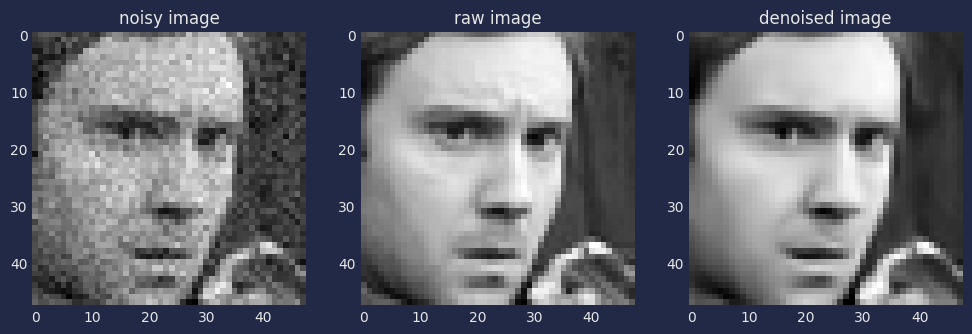

In [16]:
index = 0
img = np.array(df["pixels"].loc[index]).reshape(48,48)
noisy_img = np.array(df["noisy"].loc[index]).reshape(48,48)

model.cpu()
model.eval()
input_tensor = torch.tensor(noisy_img).reshape(1,1,48,48).type(torch.float32)
denoised = model(input_tensor)

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title("noisy image")
plt.imshow(noisy_img, cmap='gray')
plt.grid(False)

plt.subplot(1,3,2)
plt.title("raw image")
plt.imshow(img, cmap='gray')
plt.grid(False)

plt.subplot(1,3,3)
plt.title("denoised image")
plt.imshow(denoised.squeeze().detach().numpy(), cmap='gray')
plt.grid(False)

## Plotting diagrams:

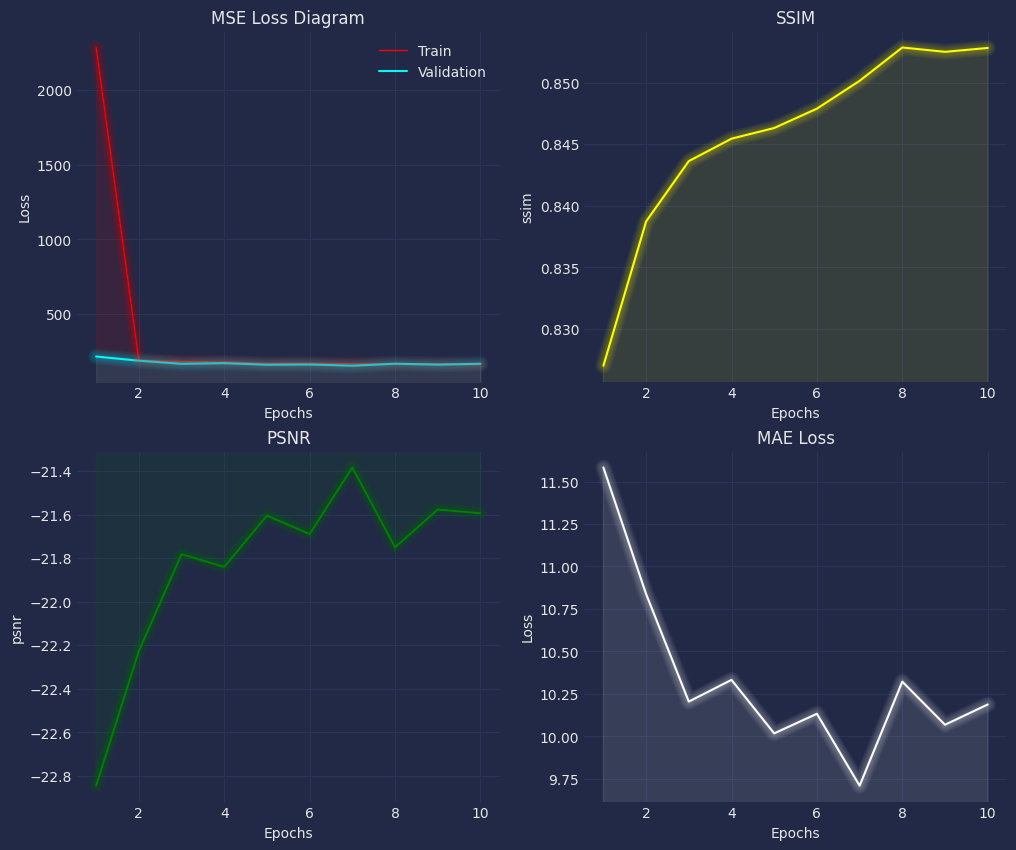

In [17]:
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot([x+1 for x in range(len(train_loss_list))], [y for y in train_loss_list], linewidth=1, c='red')
plt.plot([x+1 for x in range(len(CV_loss_list))], [y for y in CV_loss_list])
plt.title('MSE Loss Diagram')
plt.legend(["Train", "Validation"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(2, 2, 2)
plt.plot([x+1 for x in range(len(ssim_list))], [y for y in ssim_list], c='yellow')
plt.title('SSIM')
plt.xlabel('Epochs')
plt.ylabel('ssim')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(2, 2, 3)
plt.plot([x+1 for x in range(len(psnr_list))], [y for y in psnr_list], c='green')
plt.title('PSNR')
plt.xlabel('Epochs')
plt.ylabel('psnr')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(2, 2, 4)
plt.plot([x+1 for x in range(len(mae_list))], [y for y in mae_list], c='white')
plt.title('MAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.show()

## Test loss:

In [18]:
model.to("cuda:1")
test_loss = 0
total_psnr = 0
total_ssim = 0
total_mae = 0
with torch.no_grad():
    for (imgs, noisy_imgs) in test_loader:

        noisy_imgs = noisy_imgs.type(torch.float32).requires_grad_().to("cuda:1")
        imgs = imgs.to("cuda:1")
        denoised = model(noisy_imgs)

        loss = criterion(denoised, imgs)
        test_loss += loss.item()  

        psnr = compute_psnr(denoised, imgs)
        total_psnr += psnr.item()

        ssim = ssim_metric(denoised, imgs)
        total_ssim += ssim.item()

        mae = compute_mae(denoised, imgs)
        total_mae += mae.item()

test_loss = test_loss / len(test_loader)
test_psnr = total_psnr / len(test_loader)
test_ssim = total_ssim / len(test_loader)
test_mae = total_mae / len(test_loader)
print(f"Final MSE loss of the test set:  {test_loss:.3f} \nPSNR: {test_psnr:.3f} \nSSIM: {test_ssim:.3f} \nMAE: {test_mae:.3f} ")

Final MSE loss of the test set:  69.960 
PSNR: -18.443 
SSIM: 0.866 
MAE: 6.442 


In [19]:
torch.save(model, "U-Net_denoise.pth")